# CS146 Final Project 
### Alexandra Pukhova 
### December 21, 2018

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import pystan
%matplotlib inline
import seaborn
import math

In [2]:
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

In [117]:
'''Loading the Data'''
df = pd.read_csv('weekly_in_situ_co2_mlo (4).csv', sep=';')
df['Measurement Date'] = pd.to_datetime(df['Measurement Date'], format='%m/%d/%Y')
df.head(5)

,Measurement Date,CO2 Level
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


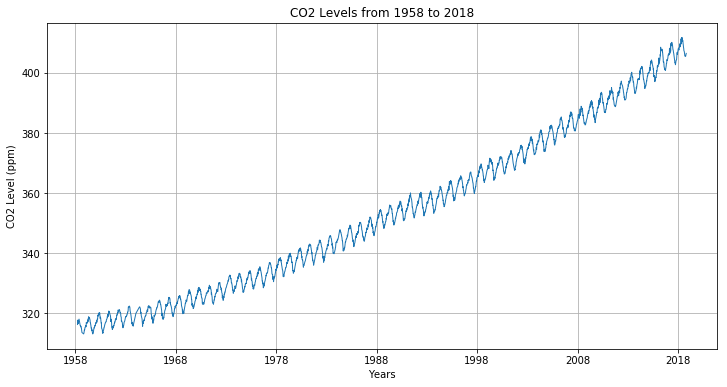

In [478]:
'''Visualizing the Data Set'''

plt.figure(figsize=(12, 6))
plt.plot(df['Measurement Date'], df['CO2 Level'], linewidth=1, alpha=1)
plt.xlabel('Years')
plt.ylabel('CO2 Level (ppm)')
plt.title('CO2 Levels from 1958 to 2018')
plt.grid()
plt.show()

In [5]:
'''Calculating Time-Passed'''

passed = []

for i in range(df.shape[0]):
    passed.append((df['Measurement Date'].iloc[i]-(df['Measurement Date'].iloc[0])).days)
    
df_1 = pd.concat([pd.Series(passed), df['CO2 Level']], axis=1)
df_1.columns = ['Days Passed', 'CO2 Level']
df_1.head(5)

,Days Passed,CO2 Level
0,0,316.19
1,7,317.31
2,14,317.69
3,21,317.58
4,28,316.48


In [6]:
# Transforming data to years but leaving the name Days Passed
# to avoid future reference confusion

df_2 = df_1.copy()
df_2['Days Passed'] = df_2['Days Passed']/365.25 

df_2.tail(5)

,Days Passed,CO2 Level
3086,60.503765,405.56
3087,60.522930,405.56
3088,60.542094,405.91
3089,60.561259,406.42
3090,60.580424,406.51


In [7]:
'''Generating Data for Future Predictions'''

preds = pd.DataFrame(data=pd.date_range(start='11/03/2018', end ='11/02/2058', freq='7D'))

df1 = df['Measurement Date']  

result = pd.concat([df1, preds], axis=0, ignore_index=True)
result.columns = ['Date'] 

passed_predictions = []

for i in range(result.shape[0]):
    passed_predictions.append((result['Date'].iloc[i]-(result['Date'].iloc[0])).days)
    
df_3 = pd.DataFrame(data=passed_predictions)
df_3.columns = ['Days Passed']
df_3.tail(5)

,Days Passed
5174,36715
5175,36722
5176,36729
5177,36736
5178,36743


In [9]:
'''Days to Years'''
# Transforming data to years but leaving the name Days Passed
# to avoid future reference confusion

df_4 = df_3.copy()
df_4['Days Passed'] = df_3['Days Passed']/365.25

df_4.tail(5)

,Days Passed
5174,100.520192
5175,100.539357
5176,100.558522
5177,100.577687
5178,100.596851


Might want ot rescale my data [0,1] and [0,1] for both - so normalize the data we can then set sigmas

## Model Comparison: Long-Term Trend

In [13]:
stan_data = {
    'N': df_2.shape[0],# length of data
    'co2_level': df_2['CO2 Level'], # CO2 level data
    'days_passed': df_2['Days Passed'] # time passed since the first measurement date
}

### Model #1: Linear

In [273]:
stan_code_lin = '''
data {
    int<lower=0> N;
    real<lower=0> days_passed[N];
    real<lower=0> co2_level[N];
}

parameters {
    real<lower=0> sigma; // noise 
    real<lower=0> c_0; // parameter c_0
    real<lower=0> c_1; // parameter c_1

}

model {
    
    // Priors
    sigma ~ normal(0, 10);
    c_0 ~ normal(300, 30); // the intercept
    c_1 ~ normal(0,10);
    
    // Likelihood function
    for (i in 1:N){        
        co2_level[i] ~ normal(c_0 + c_1*days_passed[i], sigma);
    } 
    
}    
    

'''

stan_model_lin = pystan.StanModel(model_code=stan_code_lin)


In [274]:
results_lin = stan_model_lin.sampling(data=stan_data, iter=2000, n_jobs=3)
print(results_lin)

Inference for Stan model: anon_model_4e5a276b00c3541c8beb9bca073af124.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma   4.13  1.6e-3   0.05   4.03   4.09   4.13   4.17   4.23 1148.0    1.0
c_0   306.36  3.5e-3   0.15 306.06 306.26 306.36 306.47 306.66 1932.0    1.0
c_1     1.56  1.1e-4 4.4e-3   1.55   1.56   1.56   1.56   1.57 1644.0    1.0
lp__   -5921    0.04   1.26  -5924  -5922  -5921  -5920  -5920 1201.0    1.0

Samples were drawn using NUTS at Thu Dec 20 13:53:21 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Model #2: Quadratic

In [275]:
stan_code_quad = '''
data {
    int<lower=0> N;    
    real<lower=0> days_passed[N]; 
    real<lower=0> co2_level[N]; 
}

parameters {
    real<lower=0> sigma; // noise 
    real<lower=0> c_0; // parameter c_0
    real<lower=0> c_1; // parameter c_1
    real<lower=0> c_2; // parameter c_2

}

model {
    
    // Priors
    sigma ~ normal(0, 10);
    c_0 ~ normal(300, 30); // the intercept
    c_1 ~ normal(0,10);
    c_2 ~ normal(0,10);
    
    // Likelihood function
    for (i in 1:N){        
        co2_level[i] ~ normal(c_0 + c_1*days_passed[i] + c_2*(days_passed[i]^2), sigma);
    } 
    
}    
    

'''

stan_model_quad = pystan.StanModel(model_code=stan_code_quad)


In [276]:
results_quad = stan_model_quad.sampling(data=stan_data, iter=2000, n_jobs=3)
print(results_quad)

Inference for Stan model: anon_model_74b3c5a738817da80f1c61bc8edddc5f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma   2.24  7.1e-4   0.03   2.19   2.22   2.24   2.26    2.3 1592.0    1.0
c_0    314.5  3.5e-3   0.13 314.25 314.41 314.49 314.58 314.75 1352.0    1.0
c_1     0.78  2.9e-4 9.7e-3   0.76   0.77   0.78   0.78    0.8 1083.0    1.0
c_2     0.01  4.6e-6 1.5e-4   0.01   0.01   0.01   0.01   0.01 1103.0    1.0
lp__   -4040    0.04   1.41  -4044  -4041  -4040  -4039  -4039 1347.0    1.0

Samples were drawn using NUTS at Thu Dec 20 13:56:57 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Model #3: Exponential

In [279]:
stan_code_exp = '''
data {
    int<lower=0> N; 
    real<lower=0> days_passed[N]; 
    real<lower=0> co2_level[N]; 
}

parameters {
    real<lower=0> sigma; // noise 
    real<lower=0> c_0; // parameter c_0
    real<lower=0> lambda; // parameter lambda

}

model {
    // Priors
    sigma ~ normal(0, 10);
    c_0 ~ normal(300,30);
    lambda ~ normal(0,10);
    
    // Likelihood function
    for (i in 1:N){        
        co2_level[i] ~ normal(c_0 * exp(lambda*days_passed[i]), sigma); //y ≈ c_0*exp(lambda*x)
    } 
    
}    
    

'''

stan_model_exp = pystan.StanModel(model_code=stan_code_exp)


In [281]:
results_exp = stan_model_exp.sampling(data=stan_data, iter=6000, n_jobs=3)
print(results_exp)

Inference for Stan model: anon_model_62d014545f1d4525e62d5f5fc37e17c3.
4 chains, each with iter=6000; warmup=3000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=12000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma    3.38  7.7e-4   0.04    3.3   3.35   3.38   3.41   3.47 3146.0    1.0
c_0     308.2  1.4e-3   0.12 307.97 308.12  308.2 308.28 308.43 6396.0    1.0
lambda 4.4e-3  1.3e-710.0e-6 4.4e-3 4.4e-3 4.4e-3 4.4e-3 4.5e-3 5902.0    1.0
lp__    -5309    0.02   1.25  -5312  -5309  -5308  -5308  -5307 3384.0    1.0

Samples were drawn using NUTS at Thu Dec 20 14:06:25 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### RMSE across three models

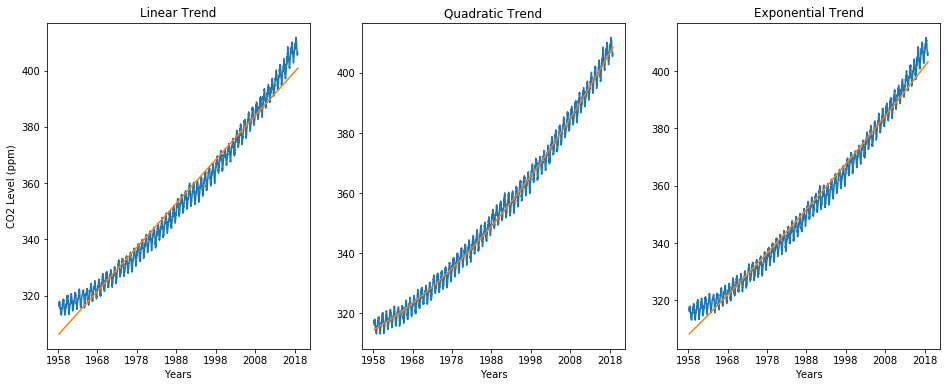

In [319]:
t = df_2['Days Passed'].values

samples_exp= results_exp.extract()
noise_exp = samples_exp['sigma']
c_0_exp = samples_exp['c_0']
lambda_exp = samples_exp['lambda']
f_exp = c_0_exp.mean()*(np.exp(lambda_exp.mean()*t))


samples_lin= results_lin.extract()
noise_lin = samples_lin['sigma']
c_0_lin = samples_lin['c_0']
c_1_lin = samples_lin['c_1']
f_lin = c_0_lin.mean()+c_1_lin.mean()*t


samples_quad= results_quad.extract()
noise_quad = samples_quad['sigma']
c_0_quad = samples_quad['c_0']
c_1_quad = samples_quad['c_1']
c_2_quad = samples_quad['c_2']
f_quad = c_0_quad.mean()+c_1_quad.mean()*t+c_2_quad.mean()*t**2

plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
plt.plot(t1, df_2['CO2 Level'].values)
plt.plot(t1, f_lin)
plt.xlabel('Years')
plt.ylabel('CO2 Level (ppm)')
plt.title('Linear Trend')

plt.subplot(1, 3, 2)
plt.plot(t1, df_2['CO2 Level'].values)
plt.plot(t1, f_quad)
plt.xlabel('Years')
plt.title('Quadratic Trend')

plt.subplot(1, 3, 3)
plt.plot(t1, df_2['CO2 Level'].values)
plt.plot(t1, f_exp)
plt.xlabel('Years')
plt.title('Exponential Trend')

plt.show()

In [176]:
f1 = list(df_2['CO2 Level'])

resids_lin = (f_lin-f1)
resids_quad = (f_quad-f1)
resids_exp = (f_exp-f1)

print ('RMSE for the linear trend is equal to ' + str(np.sqrt(np.mean(resids_lin**2))))
print ('RMSE for the quadratic trend is equal to ' + str(np.sqrt(np.mean(resids_quad**2))))
print ('RMSE for the exponential trend is equal to ' + str(np.sqrt(np.mean(resids_exp**2))))

RMSE for the linear trend is equal to 4.127394343071665
RMSE for the quadratic trend is equal to 2.241662149897764
RMSE for the exponential trend is equal to 3.3791754150269315


## Model Comparison: Seasonality

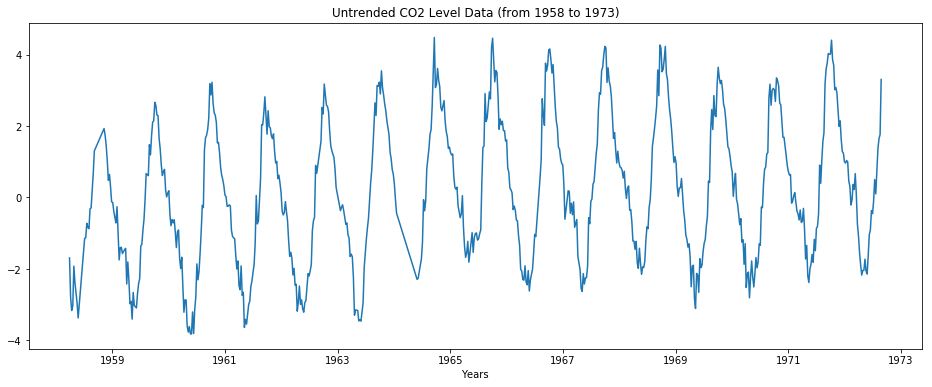

In [317]:
'''Untrended Data'''

t1 = df['Measurement Date'].values

plt.figure(figsize=(16, 6))
plt.plot(t1[:700],resids_quad[:700])
plt.xlabel('Years')
plt.title('Untrended CO2 Level Data (from 1958 to 1973)')
plt.show()

In [30]:
stan_data_season = {
    'N': df_2.shape[0],
    'co2_level': resids_quad,
    'days_passed': df_2['Days Passed']
}

### Model #1: Sine

In [290]:
stan_code_sin = '''
data {
    int<lower=0> N;    
    real<lower=0> days_passed[N];
    real co2_level[N];    
    
}

parameters {
    
    real<lower=0> sigma; // noise
    real<lower=0> amplitude;  
    // Periodic phi
    real phi_x;
    real phi_y;

}

transformed parameters {
    real phi; // phi = phase
    phi = atan2(phi_x, phi_y);
}

model {
    
    // Priors
    sigma ~ normal(0, 10);
    amplitude ~ normal(0, 10);
    
    // Likelihood function
    for (i in 1:N){        
        co2_level[i] ~ normal(amplitude*sin(2*pi()*days_passed[i]+phi), sigma);
    }
    
}    
    

'''

stan_model_sin = pystan.StanModel(model_code=stan_code_sin)

In [291]:
parameters_sin = ['amplitude', 'phi', 'sigma']

results_sin = stan_model_sin.sampling(data=stan_data_season, iter=1000, n_jobs=3)
print(results_sin.stansummary(pars=parameters_sin))

Inference for Stan model: anon_model_e77954c17d383975abe905fe3a436343.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
amplitude   2.86  6.0e-4   0.02   2.81   2.84   2.86   2.87   2.91 1740.0    1.0
phi        -1.99  3.0e-4 8.6e-3   -2.0  -1.99  -1.99  -1.98  -1.97  794.0    1.0
sigma       0.97  2.8e-4   0.01   0.95   0.96   0.97   0.98    1.0 1979.0    1.0

Samples were drawn using NUTS at Thu Dec 20 14:28:05 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


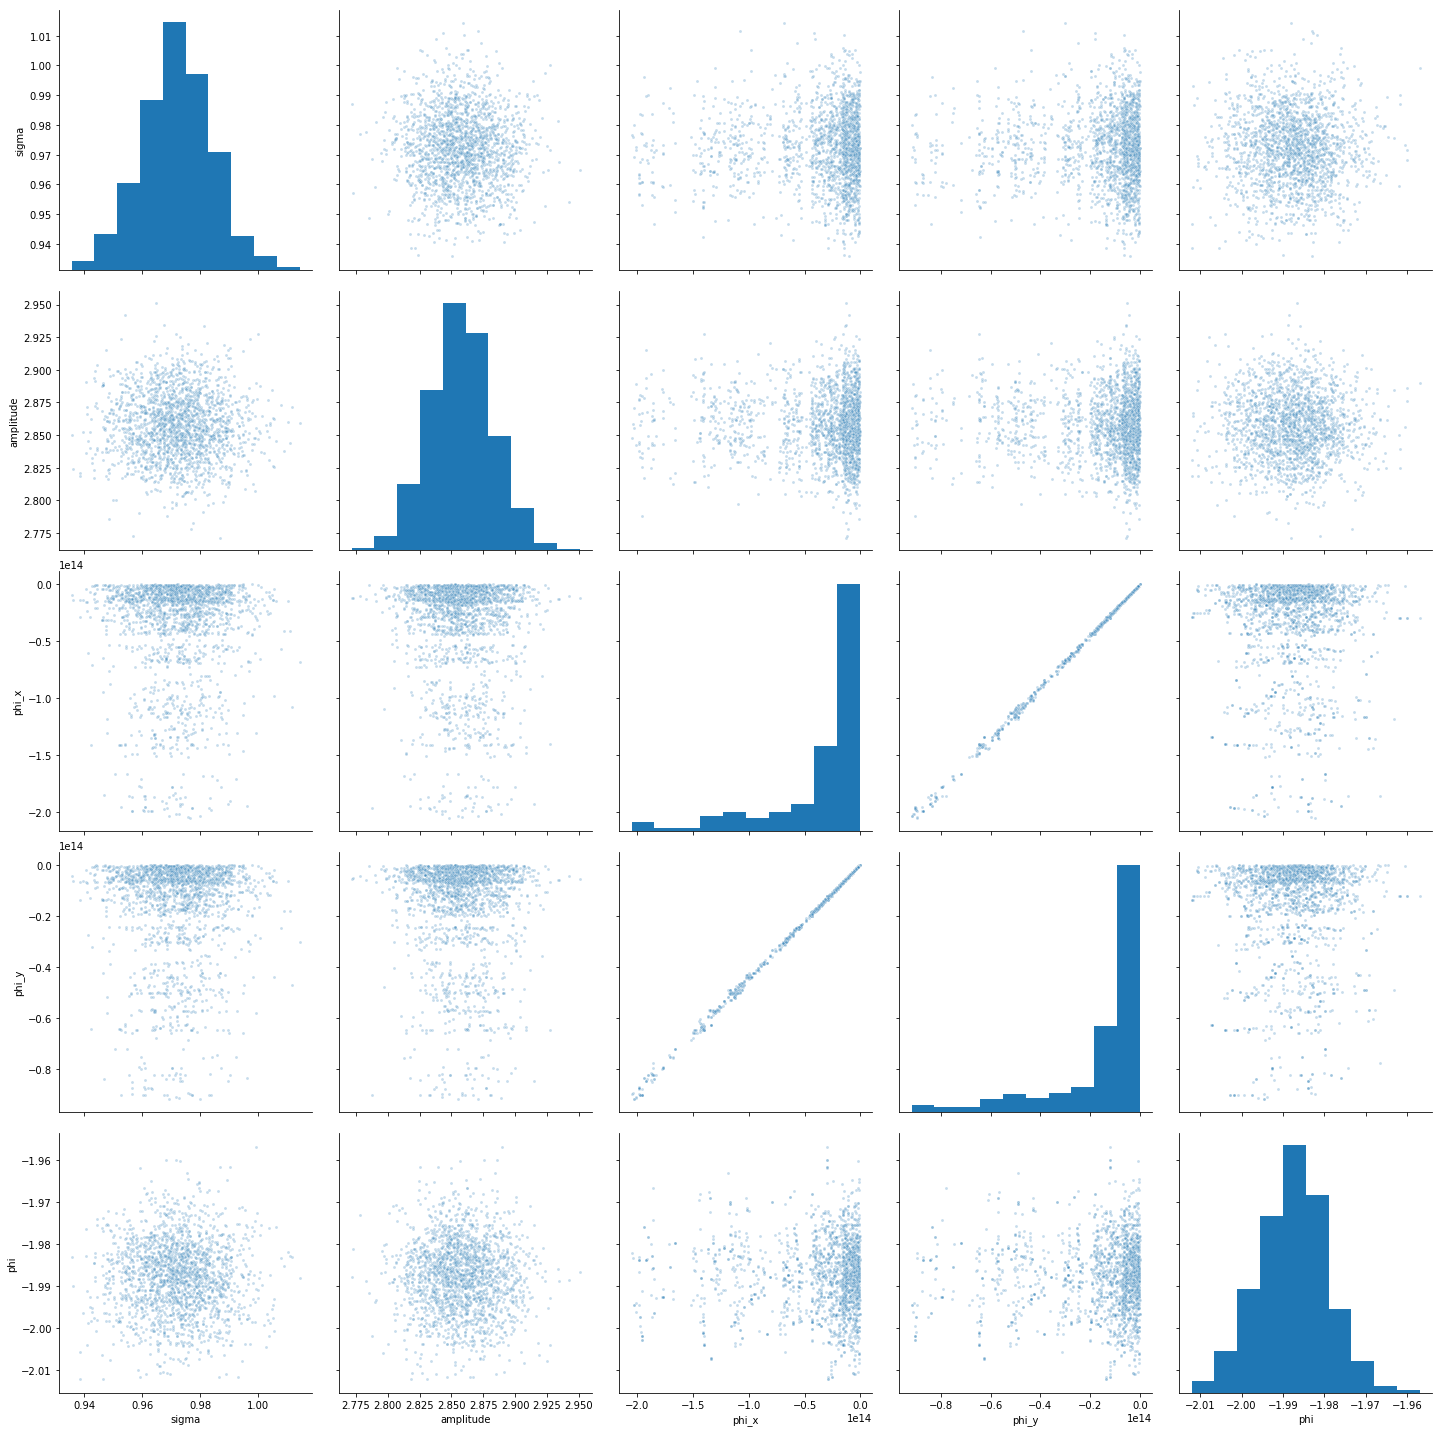

In [33]:
# Pair plot of the posteriors over all parameters of the sine model.

parameters = ['sigma', 'amplitude', 'phi_x','phi_y', 'phi']
samples_sin = results_sin.extract()
df = pd.DataFrame(
    data=np.transpose([samples_sin[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=4, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

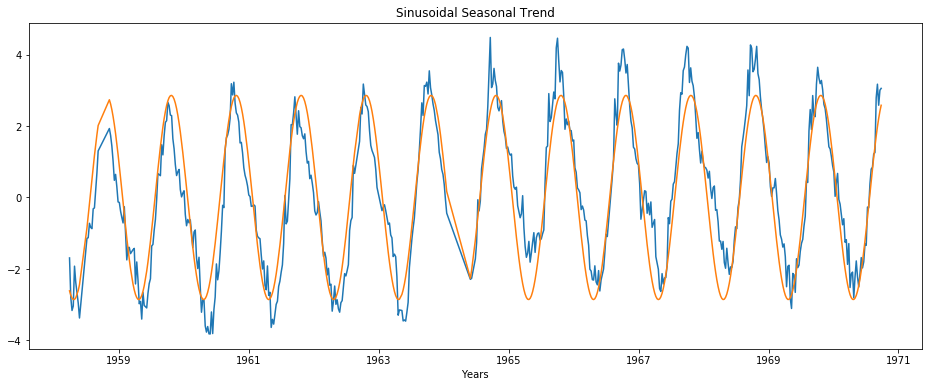

In [315]:
samples_sin= results_sin.extract()
phi_sin = samples_sin['phi']
amplitude_sin = samples_sin['amplitude']
t = df_2['Days Passed'].values

f_sin = amplitude_sin.mean()*np.sin(2*np.pi*t+phi_sin.mean())

plt.figure(figsize=(16, 6))
plt.plot(t1[:600], resids_quad[:600])
plt.plot(t1[:600], f_sin[:600])
plt.xlabel('Years')
plt.title('Sinusoidal Seasonal Trend')
plt.show()

### Model #2: "Tilted" Sine

In [292]:
stan_code_tilt_sin = '''
data {
    int<lower=0> N;   
    real<lower=0> days_passed[N]; 
    real co2_level[N];    
    
}

parameters {
    
    real<lower=0> sigma; // noise
    real<lower=0> amplitude; 
    
    // Periodic phi
    real phi_x;
    real phi_y;
    
    // real phi_x_1;
    // real phi_y_1;

}

transformed parameters {
    real phi; // phi = phase
    phi = atan2(phi_x, phi_y);
    
}

model {
    
    // Priors
    sigma ~ normal(0, 10);
    amplitude ~ normal(0,10);
    
    // Likelihood function
    for (i in 1:N){        
        co2_level[i] ~ normal(amplitude*sin(2*pi()*days_passed[i]+0.5*sin(2*pi()*days_passed[i]+phi)+phi), sigma); 
        
    }
    
}    
    

'''

stan_model_tilt_sin = pystan.StanModel(model_code=stan_code_tilt_sin)

In [295]:
parameters_tilt_sin = ['amplitude', 'phi', 'sigma']

results_tilt_sin = stan_model_tilt_sin.sampling(data=stan_data_season, iter=4000, n_jobs=3)
print(results_tilt_sin.stansummary(pars=parameters_tilt_sin))

Inference for Stan model: anon_model_bed432638e8ed87182232998a9d007d1.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
amplitude   3.14  8.7e-4   0.02    3.1   3.13   3.14   3.16   3.19  688.0   1.01
phi        -2.02  1.1e-4 6.3e-3  -2.03  -2.02  -2.02  -2.01  -2.01 3586.0    1.0
sigma       0.81  4.0e-4   0.01   0.79    0.8   0.81   0.81   0.83  654.0   1.01

Samples were drawn using NUTS at Thu Dec 20 14:40:18 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


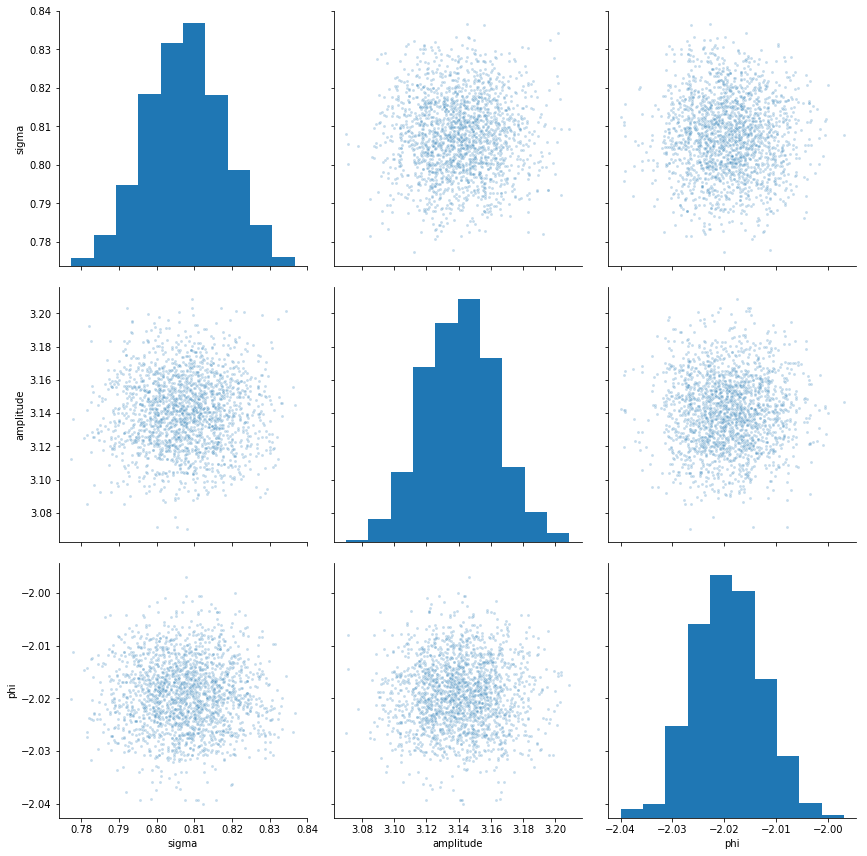

In [227]:
parameters_tilt = ['sigma', 'amplitude', 'phi']
samples_tilt_sin = results_tilt_sin.extract()
df_tilt = pd.DataFrame(
    data=np.transpose([samples_tilt_sin[param] for param in parameters_tilt]),
    columns=parameters_tilt)
seaborn.pairplot(df_tilt, size=4, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

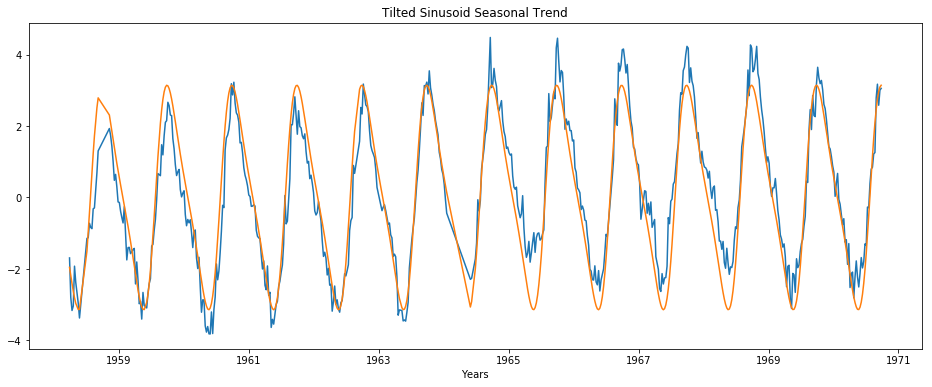

In [316]:
samples_tilt_sin= results_tilt_sin.extract()
amplitude_tilt_sin = samples_tilt_sin['amplitude']
phi_tilt_sin = samples_tilt_sin['phi']

t = df_2['Days Passed'].values

f_tilt_sin = amplitude_tilt_sin.mean()*np.sin(2*np.pi*t+0.5*np.sin(2*np.pi*t+phi_tilt_sin.mean())+phi_tilt_sin.mean())

plt.figure(figsize=(16, 6))
plt.plot(t1[:600], resids_quad[:600])
plt.plot(t1[:600], f_tilt_sin[:600])
plt.xlabel('Years')
plt.title('Tilted Sinusoid Seasonal Trend')
plt.show()

In [289]:
f1 = list(resids_quad)

resids_sin = (f_sin-f1)
resids_tilt_sin = (f_tilt_sin-f1)


print ('RMSE for the sine trend is equal to ' + str(np.sqrt(np.mean(resids_sin**2))))
print ('RMSE for the tilted sine trend is equal to ' + str(np.sqrt(np.mean(resids_tilt_sin**2))))

RMSE for the sine trend is equal to 0.9714038071387873
RMSE for the tilted sine trend is equal to 0.80703599944415


## Model: Noise

Can we make a noise model ro will it get accounted for with the SD of each both the general and the seasonality trends?

## Cumulative Model: Quadratic + Tilted Sine

In [296]:
stan_code_cumulative = '''
data {
    int<lower=0> N;    
    real<lower=0> days_passed[N]; 
    real co2_level[N]; 
}

parameters {
    real<lower=0> sigma; // noise 
    real<lower=0> c_0; // parameter c_0
    real<lower=0> c_1; // parameter c_1
    real<lower=0> c_2; // parameter c_2

    real<lower=0> amplitude;  
    
    // Periodic phi
    real phi_x;
    real phi_y;
}

transformed parameters {
    real phi; // phi = phase
    phi = atan2(phi_x, phi_y);
}

model {
    
    // Priors
    sigma ~ normal(0, 10);

    c_0 ~ normal(300, 30); // the intercept
    c_1 ~ normal(0,10);
    c_2 ~ normal(0,10);
    
    amplitude ~ normal(0,10);
    
    // Likelihood function
    for (i in 1:N){        
        co2_level[i] ~ normal(c_0 + c_1*days_passed[i] + c_2*(days_passed[i]^2) + amplitude*sin(2*pi()*days_passed[i]+0.5*sin(2*pi()*days_passed[i]+phi)+phi), sigma);

    }
    
}    
    

'''

stan_model_cumulative = pystan.StanModel(model_code=stan_code_cumulative)


In [238]:
stan_data_cumulative = {
    'N': df_2.shape[0],
    'co2_level': df_2['CO2 Level'],
    'days_passed': df_2['Days Passed']
}

In [297]:
parameters_cumulative = ['c_0', 'c_1', 'c_2', 'amplitude', 'phi', 'sigma']

results_cumulative = stan_model_cumulative.sampling(data=stan_data_cumulative, iter=2000, n_jobs=3)
print(results_cumulative.stansummary(pars=parameters_cumulative))

Inference for Stan model: anon_model_f8e4a9eda1f76c775208bc966805eca7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c_0       314.52  1.3e-3   0.08 314.37 314.47 314.52 314.57 314.66 3579.0    1.0
c_1         0.78  9.6e-5 5.5e-3   0.77   0.77   0.78   0.78   0.79 3325.0    1.0
c_2         0.01  1.5e-6 8.7e-5   0.01   0.01   0.01   0.01   0.01 3338.0    1.0
amplitude   2.72  5.7e-4   0.04   2.65    2.7   2.72   2.74   2.79 4079.0    1.0
phi         1.21  3.3e-4   0.01   1.18    1.2   1.21   1.21   1.23 2055.0    1.0
sigma       1.33  2.6e-4   0.02    1.3   1.32   1.33   1.34   1.36 4045.0    1.0

Samples were drawn using NUTS at Thu Dec 20 15:19:47 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


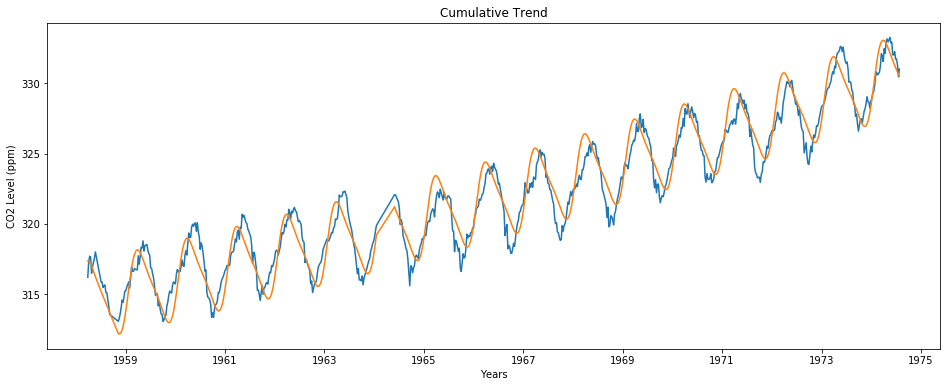

In [320]:
t = df_2['Days Passed'].values

samples_cummulative= results_cummulative.extract()
noise_cummulative = samples_cummulative['sigma']
c_0_cummulative = samples_cummulative['c_0']
c_1_cummulative = samples_cummulative['c_1']
c_2_cummulative = samples_cummulative['c_2']
phi_cummulative = samples_cummulative['phi']
amplitude_cummulative = samples_cummulative['amplitude']
f_cummulative = c_0_cummulative.mean()+c_1_cummulative.mean()*t+c_2_cummulative.mean()*t**2+amplitude_cummulative.mean()*np.sin(2*np.pi*t+0.5*np.sin(2*np.pi*t+phi_cummulative.mean())+
                                        phi_cummulative.mean())

plt.figure(figsize=(16, 6))
plt.plot(t1[:800], df_2['CO2 Level'].values[:800])
plt.plot(t1[:800], f_cummulative[:800])
plt.xlabel('Years')
plt.ylabel('CO2 Level (ppm)')
plt.title('Cumulative Trend')
plt.plot()
plt.show()

### Predictions

In [41]:
n_future_total = df_3.shape[0]

In [244]:
stan_data_cumulative_predictions = {
    'N': df_2.shape[0],# length of observed data
    'co2_level': df_2['CO2 Level'], # obsreved data, equivalent to df_3['Days Passed'][:3091]
    'days_passed': df_4['Days Passed'], # observed dates + prediction dates in years
    'n_future_total': n_future_total # number of obsrved data points + predictions
}

In [299]:
stan_code_cumulative_predictions = '''
data {
    int<lower=0> N;    //length of observed data
    real co2_level[N]; //observed data
    int<lower=0> n_future_total; // number of TOTAL values to predict (observed + unobserved)
    real<lower=0> days_passed[n_future_total]; // observed dates + prediction dates
}

parameters {
    real<lower=0> sigma; // noise 
    real<lower=0> c_0; // parameter c_0
    real<lower=0> c_1; // parameter c_1
    real<lower=0> c_2; // parameter c_2

    real<lower=0> amplitude; // 
    
    // Periodic phi
    real phi_x;
    real phi_y;
}

transformed parameters {
    real phi; // phi = phase
    phi = atan2(phi_x, phi_y);
}

model {
    
    // Priors
    sigma ~ normal(0, 10);

    c_0 ~ normal(300, 30); // the intercept
    c_1 ~ normal(0,10);
    c_2 ~ normal(0,10);
    
    amplitude ~ normal(0,10);
    
    // Likelihood function
    for (i in 1:N){        
        co2_level[i] ~ normal(c_0 + c_1*days_passed[i] + c_2*(days_passed[i]^2) + amplitude*sin(2*pi()*days_passed[i]+0.5*sin(2*pi()*days_passed[i]+phi)+phi), sigma);

    }
}

generated quantities {
    real x_future[n_future_total-N]; // predictions to make
    
    for(i in (N+1):n_future_total) {
        x_future[i-N] = normal_rng(
            c_0 + c_1*days_passed[i] + c_2*(days_passed[i]^2) + amplitude*sin(2*pi()*days_passed[i]+0.5*sin(2*pi()*days_passed[i]+phi)+phi),
            sigma);
    } 
}
    
'''

stan_model_cumulative_predictions = pystan.StanModel(model_code=stan_code_cummulative_predictions)


In [300]:
parameters_pred = ['c_0', 'c_1', 'c_2', 'amplitude', 'phi', 'sigma']

results_cumulative_predictions = stan_model_cumulative_predictions.sampling(data=stan_data_cumulative_predictions, iter=2000)
print(results_cumulative_predictions.stansummary(pars=parameters_pred))
samples_cumulative_predictions = results_cumulative_predictions.extract()

Inference for Stan model: anon_model_c81205a992b47485ff6a590199979f72.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c_0       314.51  9.6e-4   0.05  314.4 314.47  314.5 314.54 314.62 3226.0    1.0
c_1         0.78  7.3e-5 4.1e-3   0.77   0.77   0.78   0.78   0.79 3114.0    1.0
c_2         0.01  1.1e-6 6.5e-5   0.01   0.01   0.01   0.01   0.01 3187.0    1.0
amplitude   2.86  3.8e-4   0.02   2.81   2.84   2.86   2.87   2.91 4165.0    1.0
phi         1.15  1.9e-4 8.8e-3   1.14   1.15   1.15   1.16   1.17 2076.0    1.0
sigma       0.97  1.9e-4   0.01   0.95   0.96   0.97   0.98    1.0 3972.0    1.0

Samples were drawn using NUTS at Thu Dec 20 15:53:21 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [301]:
prediction = samples_cumulative_predictions['x_future']

N = df_2.shape[0]
n_future_total = df_3.shape[0]

pred_to_plot = np.mean(prediction, axis=0)

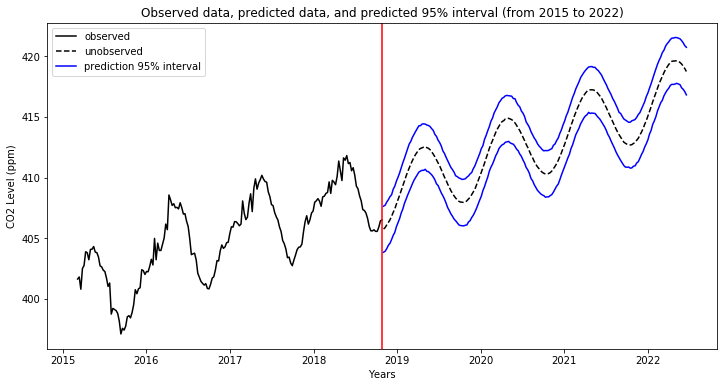

In [323]:
# Compute 95% interval of the predicted values
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
plt.plot(df['Measurement Date'].iloc[2900:], df_2['CO2 Level'].iloc[2900:], 'k-', label='observed')

plt.plot(preds[:190], pred_to_plot[:190], 'k--', label='unobserved')

plt.axvline(df['Measurement Date'].iloc[-1], color='red')

plt.plot(preds[:190],prediction_interval[0,:][:190],'b-', label='prediction 95% interval')

plt.plot(preds[:190],prediction_interval[1,:][:190],'b-')

plt.legend()
plt.xlabel('Years')
plt.ylabel('CO2 Level (ppm)')

plt.title('Observed data, predicted data, and predicted 95% interval (from 2015 to 2022)')
plt.show()

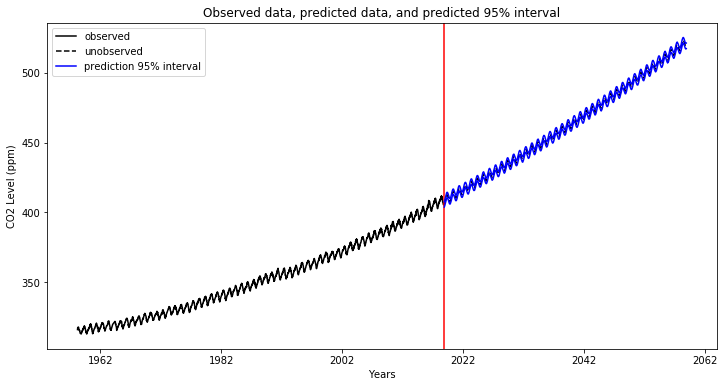

In [322]:
# Compute 95% interval of the predicted values
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
plt.plot(df['Measurement Date'].values, df_2['CO2 Level'].values, 'k-', label='observed')

plt.plot(preds, pred_to_plot, 'k--', label='unobserved')

plt.axvline(df['Measurement Date'].iloc[-1], color='red')

plt.plot(preds,prediction_interval[0,:],'b-', label='prediction 95% interval')

plt.plot(preds,prediction_interval[1,:],'b-')

plt.legend()
plt.xlabel('Years')
plt.ylabel('CO2 Level (ppm)')

plt.title('Observed data, predicted data, and predicted 95% interval')
plt.show()

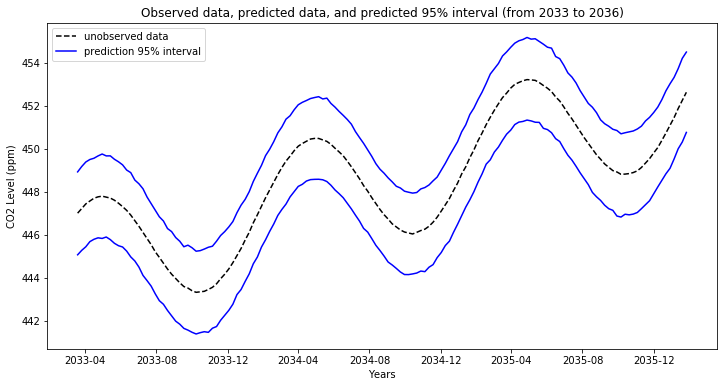

In [459]:
# Compute 95% interval of the predicted values
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))

plt.plot(preds[750:900], pred_to_plot[750:900], 'k--', label='unobserved data')

plt.plot(preds[750:900],prediction_interval[0,:][750:900],'b-', label='prediction 95% interval')

plt.plot(preds[750:900],prediction_interval[1,:][750:900],'b-')

plt.legend()
plt.xlabel('Years')
plt.ylabel('CO2 Level (ppm)')

plt.title('Observed data, predicted data, and predicted 95% interval (from 2033 to 2036)')
plt.show()

In [356]:
lower = prediction_interval[0,:][-44]
upper = prediction_interval[1,:][-44]
CI = lower, upper
print 'The 95 percent confidence interval for the atmospheric CO₂ levels for January 5, 2058 is between '+str(lower)+' and ' + str(upper)

The 95 percent confidence interval for the atmospheric CO₂ levels for January 5, 2058 is between 516.4854129904398 and 520.5180688087075


In [456]:
# Hitting the 450ppm mark

print float(prediction_interval[1,:][np.argwhere(prediction_interval[1,:]>450)[0]])
print preds.values[np.argwhere(prediction_interval[1,:]>450)[0]]

print float(pred_to_plot[np.argwhere(pred_to_plot>450)[0]])
print preds.values[np.argwhere(pred_to_plot>450)[0]]

print float(prediction_interval[0,:][np.argwhere(prediction_interval[0,:]>450)[0]])
print preds.values[np.argwhere(prediction_interval[0,:]>450)[0]]

450.326568764
[['2034-02-18T00:00:00.000000000']]
450.117093755
[['2034-04-01T00:00:00.000000000']]
450.077332724
[['2035-03-10T00:00:00.000000000']]
